Import all necessary libraries and functions, as well as the primary data-structure

In [1]:
# This builds the full data-structure, including
# 1. initial parameter and covariate sets
# 2. pre-processing settings and additional parameters-induced changes to data

%run fMRI_prestats_data-struct.ipynb

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


subject(s) missing!
First line of list-alignment:   FED006 FED006 FED007
Control relevant files!


 The following subjects where excluded from further analysis due to false file numbers or missing data:  
 EPI:  ['FED006'] T1:  ['FED006']
The new subject list after initial data and image file checkup:

['FED007', 'FED008', 'FED009', 'FED010', 'FED011', 'FED012', 'FED013', 'FED014', 'FED015', 'FED016', 'FED017', 'FED018', 'FED019', 'FED020', 'FED021', 'FED022', 'FED023', 'FED024', 'FED025', 'FED026', 'FED027', 'FED028', 'FED029', 'FED030', 'FED031', 'FED032', 'FED033', 'FED034', 'FED035', 'FED036', 'FED037', 'FED038', 'FED039', 'FED040', 'FED041', 'FED042', 'FED043', 'FED044', 'FED045', 'FED046', 'FED047', 'FED048', 'FED049', 'FED050', 'FED051', 'FED052', 'FED053', 'FED054', 'FED055', 'FED056', 'FED057', 'FED058', 'FED059', 'FED060', 'FED061', 'FED062', 'FED063', 'FED064', 'FED065', 'FED066', 'FED067', 'FED068']


That leaves a total of  62 remaining subjects.


The following parameters

In [2]:
# Delete all variables in the current namespace from globals except those defined at the initiation of the data structure
for var in dir():
    if (var != 'data_varspace_init' and var not in data_varspace_init):
        #print(var, " will be deleted from this notebook's global namespace")
        del globals()[var]

In [3]:
# control results
key = random.sample(data.keys(), 1)
print(data[key[0]])
print(data["general"])

{'files': ['/fMRI/FED026/FMRI.json', '/fMRI/FED026/FMRI.nii.gz', '/fMRI/FED026/FMRI_mc-bet-cr-s10.nii.gz', '/fMRI/FED026/FMRI_mc-bet-cr-s10.nii.gz_usan_size.nii.gz', '/fMRI/FED026/FMRI_mc-bet-cr-s9-m.nii', '/fMRI/FED026/FMRI_mc-bet-cr-s9.nii.gz', '/fMRI/FED026/FMRI_mc-bet-cr-s9.nii.gz_usan_size.nii.gz', '/fMRI/FED026/FMRI_mc-bet-cr.nii.gz', '/fMRI/FED026/FMRI_mc-bet-cr_mean.nii.gz', '/fMRI/FED026/FMRI_mc-bet.nii.gz', '/fMRI/FED026/FMRI_mc.nii.gz', '/fMRI/FED026/FMRI_mc_mask.nii.gz', '/fMRI/FED026/FMRI_mc_mean.nii.gz', '/fMRI/FED026/FMRI_mc_overlay.nii.gz', '/fMRI/FED026/GM_cr_mask.nii.gz', '/fMRI/FED026/GM_cr_wholebrain.nii.gz', '/fMRI/FED026/T1_BETBf35.nii', '/fMRI/FED026/T1_BETBf35_mask.nii', '/fMRI/FED026/T1_BETBf35_overlay.nii', '/fMRI/FED026/T1_GM-tpm_mask.nii.gz', '/fMRI/FED026/T1_MPRAGE.json', '/fMRI/FED026/T1_MPRAGE.nii', '/fMRI/FED026/T1_WM-tpm_mask.nii.gz', '/VBM/FED026/DARTEL_newsegment/c1CON_FED026_T1_MPRAGE_SAG_ISO_0_9_0005_20150211171144.nii', '/VBM/FED026/DARTEL_newsegme

 Pre-configurations

In [4]:
# (Re-)activate nipype's INFO output for interfaces and workflows , as we want to see what's going on
logging.getLogger('nipype.interface').setLevel("INFO")
logging.getLogger('nipype.workflow').setLevel("INFO")

In [5]:
# define additional directories
grouptemplate_dir = f"{basedir}MNI_templates/"
grouplevel_dir = f"{basedir}Grouplevel/"

# and files
grouptemplates = [f"{grouptemplate_dir}{mask}" for mask in os.listdir(grouptemplate_dir)]
spm_mnitpm = f"{tpmdir}TPM.nii"
fsl_mni = f"{fsldir}data/standard/MNI152_T1_2mm_brain_mask.nii.gz"

# and names of our original contrasts
con_names = ["ecv1_NegI-NegV", "ecv2_PosI-PosV", "ecv3_NeuI-NeuV", "dad1_NegI-NeuI", "dad2_PosI-NeuI",
             "ecvF_Enhanced-Cue-Validity", "dadF_Difficulty-Attentional-Disengagement"]

Custom functions

In [6]:
# write function to iterate over lists in adjoining pairs within the Harvard Oxford atlas
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5)..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

Template modelling for group level masks

In [8]:
# Harvard Oxford atlas for suitability and fit to hypotheses
harox_cort = datasets.fetch_atlas_harvard_oxford("cort-prob-2mm", data_dir=None, symmetric_split=False, resume=True, verbose=1)
harox_sub = datasets.fetch_atlas_harvard_oxford("sub-prob-2mm", data_dir=None, symmetric_split=False, resume=True, verbose=1)

# list of label indexing starts at 1! 0/Background is not conform with images, regional indexing starts at 0^^


Dataset created in /home/martin/nilearn_data/fsl



Downloaded 24895488 of 25716861 bytes (96.8%,    1.3s remaining) ...done. (40 seconds, 0 min)
Extracting data from /home/martin/nilearn_data/fsl/e84ad0263d578b399912ab057c50aa50/HarvardOxford.tgz..... done.


Available cortical regions via the Harvard-Oxford probabilistic atlas: 
 ['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (fo

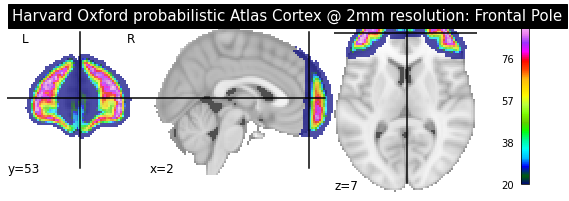

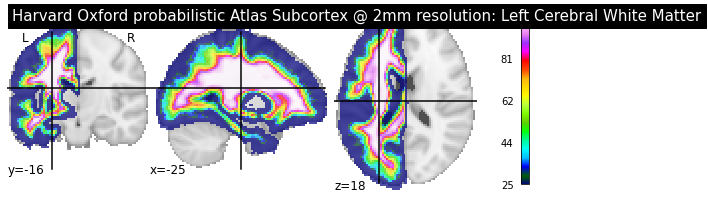

In [9]:
# print a list of available regions in two atlases
print("Available cortical regions via the Harvard-Oxford probabilistic atlas: \n", harox_cort.labels, len(harox_cort.labels))
print("\nAvailable subcortical regions via the Harvard-Oxford probabilistic atlas: \n", harox_sub.labels, len(harox_sub.labels))


# print thresholded cortical testregion (thresholding visually optimised^^)
for label in range(0, nb.load(harox_cort.maps).shape[-1] - 47):
    ni_plt.plot_roi(ni_img.index_img(harox_cort.maps, label),
                    title=f"Harvard Oxford probabilistic Atlas Cortex @ 2mm resolution: {harox_cort.labels[label+1]}", colorbar=True, vmin=20)

# print thresholded subcortical testregion (thresholding visually optimised^^)
for label in range(0, nb.load(harox_sub.maps).shape[-1] - 20):
    ni_plt.plot_roi(ni_img.index_img(harox_sub.maps, label),
                    title=f"Harvard Oxford probabilistic Atlas Subcortex @ 2mm resolution: {harox_sub.labels[label+1]}", colorbar=True, vmin=25)

In [10]:
# separate FSL's tissue propability maps Harvard_Oxford into distinct anatomical ROIs
# create dict for all ROIs and their labels
ROIs = {}

# identify important labels and collect them for each ROI by going through label-list and the Atlas image in parallel
cort_labels = [label for label in harox_cort.labels
               if re.match(r'.*(Frontal(?! Medial)|Cingulate.*anterior|Paracingulate|(?<!Planum )Temporal(?!(.*occipital|.*Fusiform))|Insula|hippocampal).*', label)]
sub_labels = [label for label in harox_sub.labels
              if re.match(r'.*(Hippo|Amygd).*', label)]

# subcortical areas are often split into left and right
# sort them by region
sub_labels = sorted([val for val in sub_labels], key=lambda val: val.split(' ', 1)[1])
# put them into tuples for later combination
sub_labels_paired = [[left, right] for left, right in pairwise(sub_labels) if left.split(' ', 1)[1] == right.split(' ', 1)[1]]
# create coherent list from items
sub_labels = [side for pair in sub_labels_paired for side in pair]
# define full list of labels, containing all relevant rois
full_labels = cort_labels + sub_labels

# control the outcome of the labelling collection
print(f"cortical labels:\n{cort_labels}\n{len(cort_labels)} labels in total\n",
      f"subcortical labels:\n{sub_labels}\n{len(sub_labels)} labels in total\n")

# associate ROIs in map object with correct labels -> into dict
for label in cort_labels:
    ROIs[label] = ni_img.index_img(harox_cort.maps, harox_cort.labels.index(label)-1)

for label in sub_labels:
    ROIs[label] = ni_img.index_img(harox_sub.maps, harox_sub.labels.index(label)-1)

# combine subcortical rois across both hemispheres (if split) into one mask image
for pair in sub_labels_paired:
    # access dict, add rois together and create new entry
    ROIs[pair[0].split(' ', 1)[1]] = ni_img.math_img('np.sum((img1, img2), axis=0)', img1=ROIs[pair[0]], img2=ROIs[pair[1]])

# drop the lateralised entries from the ROIs dict
lateral_labels = [roi for roi in full_labels if re.match(r'.*(left|right).*', roi, re.IGNORECASE)]
[ROIs.pop(roi) for roi in lateral_labels]

# combine all ROIs into one mask image
ROIs['Full_ROI_mask'] = ni_img.math_img('np.sum((allrois), axis=3)', allrois=ROIs.values())

# threshold probability images by respective value
for key in ROIs.keys():
    if key in cort_labels:
        ni_img.threshold_img(ROIs[key], 20)
    elif key in sub_labels:
        ni_img.threshold_img(ROIs[key], 25)
    # for the full mask
    else:
        ni_img.threshold_img(ROIs[key], 20)

# re-define full_labels
full_labels = [label for label in ROIs.keys()]

# binarise probability images to create masks for group analysis - for each area seperately and for the overall mask
for key in full_labels:
    ROIs[key] = ni_img.math_img('np.where(image > 0, 1, 0)', image=ROIs[key])

# save ROI masks to nii(.gz) file format
for roi in ROIs.keys():
    # also, get rid of whitespace in filenames
    group_roi_file = f"{basedir}MNI_templates/{roi.replace(' ', '-').replace(',', '')}_group.nii.gz"
    nb.save(ROIs[roi], group_roi_file)

cortical labels:
['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Paracingulate Gyrus', 'Cingulate Gyrus, anterior division', 'Frontal Orbital Cortex', 'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Frontal Operculum Cortex']
19 labels in total
 subcortical labels:
['Left Amygdala', 'Right Amygdala', 'Left Hippocampus', 'Right Hippocampus']
4 labels in total



In [11]:
# Andrew Jahn "ROI Analysis" - ROIs decide significance: Try Seitzman et al (2018) for suitability and fit to hypotheses
seitzman_rois = datasets.fetch_coords_seitzman_2018(ordered_regions=True)
# # lose the description item
# seitzman_rois.pop("description")

# all lists have the same length as the "rois" list; ROIs are represented as coordinate-arrays;
# each ROI has an entry for radius, networks and regions -> so it's al resolved down to region level^^

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [12]:
# print a list of available networks (want to use (subregions of) emotion and attention networks) in the atlas
print("Available networks via the Seitzman ROI atlas: \n", set(seitzman_rois.networks), f"\n{len(set(seitzman_rois.networks))} in total")
print("\nAvailable regions via the Seitzman ROI atlas: \n", set(seitzman_rois.regions), f"\n{len(set(seitzman_rois.regions))} in total")

# # print thresholded spherical ROIs on MNI template image for the first network in the list
# for network in networks_unique[0:1]:
#     # go through coupled lists and select by the network ID/name
#     for roi, rad, region, net_id in zip(seitzman_rois.rois, seitzman_rois.radius, seitzman_rois.regions, seitzman_rois.networks):
#         if net_id == network:
#             ni_plt.plot_roi(fsl_mni, cut_coords=roi,
#                             title=f"Seitzman ROI atlas (on MNI) coordinates of the {region} in the {net_id} network", colorbar=True)

Available networks via the Seitzman ROI atlas: 
 {'DorsalAttention', 'CinguloOpercular', 'unassigned', 'MedialTemporalLobe', 'Reward', 'Auditory', 'DefaultMode', 'ParietoMedial', 'SomatomotorLateral', 'Visual', 'Salience', 'SomatomotorDorsal', 'VentralAttention', 'FrontoParietal'} 
14 in total

Available regions via the Seitzman ROI atlas: 
 {'cerebellum', 'cortexR', 'cortexL', 'cortexMid', 'basalGanglia', 'hippocampus', 'thalamus', 'amygdala'} 
8 in total


In [13]:
# separate the Seitzman ROI atlas into distinct network ROIs
# get unique network and region values from seitzman ROI atlas
networks_unique = [ID for ID in set(seitzman_rois.networks)]
regions_unique = [reg for reg in set(seitzman_rois.regions)]

# create dict for all ROIs and their labels
ROIs = {}

# select the FPN, D/VAN and SN to be examined
networks_koster = [ID for ID in networks_unique if re.match(r'.*(Attention|Salience|Front.*Par).*', ID)]

# associate ROIs in with correct regions and networks -> into dict
for network in networks_koster:
    # create lists to collect relevant ROIs and regions per network
    ROIs[network] = {}
    ROIs[network]["spheres"] = []
    ROIs[network]["regions"] = []
    # loop over all parameters and assign the relevant items to the relevant network key
    for roi, rad, region, net_id in zip(seitzman_rois.rois, seitzman_rois.radius, seitzman_rois.regions, seitzman_rois.networks):
        if net_id == network:
            roi_sphere = nl_mask.create_sphere(roi, radius=rad, mask=fsl_mni)  # warning looked-at - irrelevant in this case^^
            ROIs[network]["spheres"].append(roi_sphere)
            ROIs[network]["regions"].append(region)

# combine ROIs across each network into one mask image
for network in ROIs.keys():
     ROIs[network]["network_mask"] = ni_img.math_img('np.sum((spheres), axis=3)', spheres=ROIs[network]["spheres"])

# # control the resulting mask images
# for network in ROIs.keys():
#     ni_plt.plot_roi(ROIs[network]["network_mask"],
#                     title=f"Seitzman ROI atlas (on MNI): Sphere-collection from all seeds/ROIs of the {network} network")

# save ROI masks to nii(.gz) file format
for network in ROIs.keys():
    group_roi_file = f"{basedir}MNI_templates/{network}_nw_group.nii.gz"
    nb.save(ROIs[network]["network_mask"], group_roi_file)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/opt/mi

In [36]:
%%script env MASKS="$grouptemplates" bash
# transfer masks to bash array and get rid of pythonean list/string characters
MASKS_arr=($(echo $MASKS | sed -e 's/[][]//g' -e 's/,//g' -e "s/'//g"))

# gunzip each mask file
for file in "${MASKS_arr[@]}"; do
gunzip $file
done

In [9]:
%%script env TEMPLATE="$spm_mnitpm" GROUPTEMPS="$grouptemplate_dir" bash

# Extract the first volume with `fslroi`
fslroi $TEMPLATE ${GROUPTEMPS}GM_PM.nii.gz 0 1

# Threshold the probability mask at 10%
fslmaths ${GROUPTEMPS}GM_PM.nii -thr 0.10 -bin ${GROUPTEMPS}GM_mask.nii.gz

# Unzip the mask and delete the GM_PM.nii file
gunzip ${GROUPTEMPS}GM_mask.nii.gz
rm ${GROUPTEMPS}GM_PM.nii.gz

# 2nd-level modelling

In [7]:
# Group FEDs etc. into MDD and CON conditions
MDD_dirs = [subdir for subdir in FED_dirs
            if data[subdir.rsplit('/', 2)[1]]["parameters"]["covariates"]["BDI 22 Score"].item() == 1]
CON_dirs = [subdir for subdir in FED_dirs
            if data[subdir.rsplit('/', 2)[1]]["parameters"]["covariates"]["BDI 22 Score"].item() == 0]

In [8]:
print(MDD_dirs, len(MDD_dirs))
print(CON_dirs, len(CON_dirs))

['/fMRI/FED011/', '/fMRI/FED014/', '/fMRI/FED018/', '/fMRI/FED027/', '/fMRI/FED028/', '/fMRI/FED029/', '/fMRI/FED030/', '/fMRI/FED031/', '/fMRI/FED032/', '/fMRI/FED033/', '/fMRI/FED034/', '/fMRI/FED035/', '/fMRI/FED036/', '/fMRI/FED037/', '/fMRI/FED038/', '/fMRI/FED039/', '/fMRI/FED040/', '/fMRI/FED041/', '/fMRI/FED042/', '/fMRI/FED043/', '/fMRI/FED044/', '/fMRI/FED045/', '/fMRI/FED046/', '/fMRI/FED047/', '/fMRI/FED051/', '/fMRI/FED052/', '/fMRI/FED055/', '/fMRI/FED057/', '/fMRI/FED059/', '/fMRI/FED066/'] 30
['/fMRI/FED007/', '/fMRI/FED008/', '/fMRI/FED009/', '/fMRI/FED010/', '/fMRI/FED012/', '/fMRI/FED013/', '/fMRI/FED015/', '/fMRI/FED016/', '/fMRI/FED017/', '/fMRI/FED019/', '/fMRI/FED020/', '/fMRI/FED021/', '/fMRI/FED022/', '/fMRI/FED023/', '/fMRI/FED024/', '/fMRI/FED025/', '/fMRI/FED026/', '/fMRI/FED049/', '/fMRI/FED050/', '/fMRI/FED053/', '/fMRI/FED054/', '/fMRI/FED056/', '/fMRI/FED058/', '/fMRI/FED060/', '/fMRI/FED061/', '/fMRI/FED062/', '/fMRI/FED063/', '/fMRI/FED064/', '/fMRI/FE

Specify 2nd level models per contrast and anat/nw mask

In [8]:
# Options for group analysis in SPM12 via nipype:
# A factorial design, a multiple regression design, one-sample T-Test design, a paired T-Test design or a two-sample T-Test design.

# gather wcon files for each of the 7 contrasts separately and by group
for con_num, con_name in zip(range(1, 8), con_names):
    # make list to hold all contrast files for this contrast by group
    mdd_allwcons = []
    con_allwcons = []
    for mdd, con in zip_longest(MDD_dirs, CON_dirs):
        # create directory template for MDD and CON
        MDDwcon_dir = f"{mdd}model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/"
        CONwcon_dir = f"{con}model_specifications/level1design/mod_estimate/1stlevel_contrast_estimates/normalize/"
        # collect the normalised contrast files in separate lists
        # account for MDDs being fewer than CONs
        if os.path.isdir(MDDwcon_dir):
            mdd_wcons = sorted([f"{MDDwcon_dir}{wcon_file}"
                               for wcon_file in os.listdir(f"{MDDwcon_dir}")
                               if re.match(fr'.*(wcon|wess)_000{con_num}.nii$', wcon_file)])
            con_wcons = sorted([f"{CONwcon_dir}{wcon_file}"
                               for wcon_file in os.listdir(f"{CONwcon_dir}")
                               if re.match(fr'.*(wcon|wess)_000{con_num}.nii$', wcon_file)])
            # extend the contrast list by the contrast file of the present subject
            mdd_allwcons.extend(mdd_wcons)
            con_allwcons.extend(con_wcons)
        else:
            con_wcons = sorted([f"{CONwcon_dir}{wcon_file}"
                               for wcon_file in os.listdir(f"{CONwcon_dir}")
                               if re.match(fr'.*(wcon|wess)_000{con_num}.nii$', wcon_file)])
            # extend the contrast list by the contrast file of the present subject
            con_allwcons.extend(con_wcons)

    # use the collected wcon files with every MNI-Atlas based ROI mask to generate a set of 2nd level models
    for mask in grouptemplates:
        # Initiate the TwoSampleTTestDesign specification node
        ttest_group = pe.Node(spm.TwoSampleTTestDesign(), name = f"{mask.rsplit('/', 1)[1].rsplit('_', 1)[0]}")
        ttest_group.inputs.group1_files = mdd_allwcons
        ttest_group.inputs.group2_files = con_allwcons
        ttest_group.inputs.explicit_mask_file = mask
        ttest_group.inputs.no_grand_mean_scaling = True  # Grand Mean Scaling not recommended for 2nd level fMRI (SPM12 manual, chapter 10)
        ttest_group.base_dir = f"{grouplevel_dir}{con_name}/"
        # run it
        res = ttest_group.run()
        # print it
        print(res.outputs)

210504-13:31:48,522 nipype.workflow INFO:
	 [Node] Setting-up "Insular-Cortex" in "/fMRI/Grouplevel/ecv1_NegI-NegV/Insular-Cortex".
210504-13:31:48,535 nipype.workflow INFO:
	 [Node] Running "Insular-Cortex" ("nipype.interfaces.spm.model.TwoSampleTTestDesign")
210504-13:31:53,737 nipype.workflow INFO:
	 [Node] Finished "Insular-Cortex".

spm_mat_file = /fMRI/Grouplevel/ecv1_NegI-NegV/Insular-Cortex/SPM.mat

210504-13:31:53,744 nipype.workflow INFO:
	 [Node] Setting-up "VentralAttention_nw" in "/fMRI/Grouplevel/ecv1_NegI-NegV/VentralAttention_nw".
210504-13:31:53,757 nipype.workflow INFO:
	 [Node] Running "VentralAttention_nw" ("nipype.interfaces.spm.model.TwoSampleTTestDesign")
210504-13:31:59,752 nipype.workflow INFO:
	 [Node] Finished "VentralAttention_nw".

spm_mat_file = /fMRI/Grouplevel/ecv1_NegI-NegV/VentralAttention_nw/SPM.mat

210504-13:31:59,758 nipype.workflow INFO:
	 [Node] Setting-up "Frontal-Orbital-Cortex" in "/fMRI/Grouplevel/ecv1_NegI-NegV/Frontal-Orbital-Cortex".
21050

Inspect exemplary 2nd level design matrices

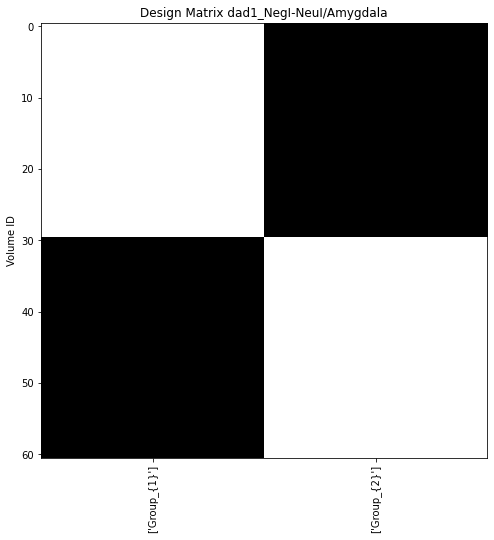

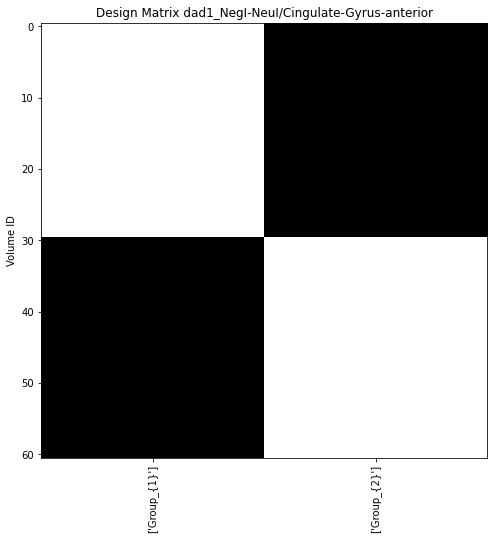

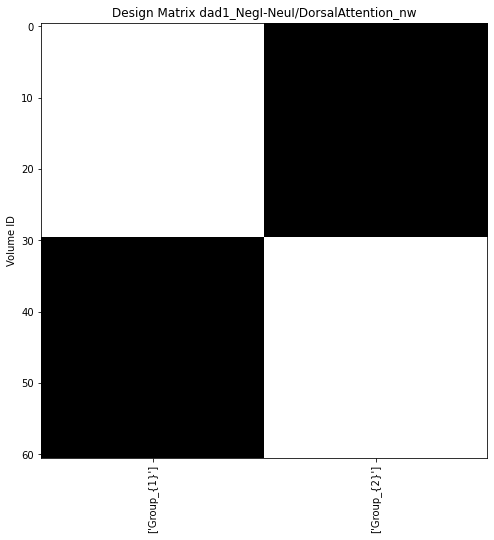

In [9]:
# print a few 2nd level design matrices to make sure everything looks alright
# define input files
mod_spec_mats = sorted([f"{grouplevel_dir}{subdir}/{maskdir}/{mat}"
                        for subdir in os.listdir(grouplevel_dir)
                        if os.path.isdir(f"{grouplevel_dir}{subdir}/")
                        for maskdir in os.listdir(f"{grouplevel_dir}{subdir}/")
                        for mat in os.listdir(f"{grouplevel_dir}{subdir}/{maskdir}/")
                        if re.match(r'.*SPM.mat$', mat)])

# Access SPM.mat via loadmat function
for spec_mat in mod_spec_mats[0:3]:
    spmmat = sp.io.loadmat(spec_mat, struct_as_record=False)
    # Design matrix and the names of the regressors are hidden in the spmmat variable, but they can be accessed as follows
    designMatrix = spmmat['SPM'][0][0].xX[0][0].X
    names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name]
    # Normalize the design matrix, so that each column has a maximum amplitude of 1.
    # This is just for visualization purposes, otherwise rotation parameters with their rather small values will not show up.
    normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
    # Plot the design matrix.
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
    plt.title(f"Design Matrix {spec_mat.rsplit('/', 3)[1]}/{spec_mat.rsplit('/', 3)[2]}")
    ax.set_ylabel('Volume ID')
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=90);  # semicolon suppresses unwanted text-output from "set*" commands

Estimate 2nd level models per contrast and anat/nw mask

In [10]:
# Many of the model specification .mat files may be empty
# write success and failure list
modest_success = []
modest_fail = []

for mat in mod_spec_mats:
    # Try to estimate the 2nd level model
    try:
        ttest_group_modest = pe.Node(spm.EstimateModel(), name = "ttest2S_modest")
        ttest_group_modest.inputs.estimation_method = {'Classical': 1}
        ttest_group_modest.inputs.spm_mat_file = mat
        ttest_group_modest.base_dir = f"{mat.rsplit('/', 1)[0]}"
        # run it
        res = ttest_group_modest.run()
        # print it
        print(res.outputs)
        print(f"Estimated 2 Sample t-Test model for {mat.rsplit('/', 3)[1:3]}", "\n")
        modest_success.append(mat.rsplit('/', 3)[1:3])
    except RuntimeError:
        print(f"{mat.rsplit('/', 3)[1:3]}: Probably empty mask. Will not be estimated", "\n")
        modest_fail.append(mat.rsplit('/', 3)[1:3])
        pass

210504-13:53:34,646 nipype.workflow INFO:
	 [Node] Setting-up "ttest2S_modest" in "/fMRI/Grouplevel/dad1_NegI-NeuI/Amygdala/ttest2S_modest".
210504-13:53:34,652 nipype.workflow INFO:
	 [Node] Running "ttest2S_modest" ("nipype.interfaces.spm.model.EstimateModel")
210504-13:53:40,212 nipype.workflow WARNING:
	 Storing result file without outputs
210504-13:53:40,215 nipype.workflow WARNING:
	 [Node] Error on "ttest2S_modest" (/fMRI/Grouplevel/dad1_NegI-NeuI/Amygdala/ttest2S_modest)
['dad1_NegI-NeuI', 'Amygdala']: Probably empty mask. Will not be estimated 

210504-13:53:40,219 nipype.workflow INFO:
	 [Node] Setting-up "ttest2S_modest" in "/fMRI/Grouplevel/dad1_NegI-NeuI/Cingulate-Gyrus-anterior/ttest2S_modest".
210504-13:53:40,225 nipype.workflow INFO:
	 [Node] Running "ttest2S_modest" ("nipype.interfaces.spm.model.EstimateModel")
210504-13:53:46,200 nipype.workflow WARNING:
	 Storing result file without outputs
210504-13:53:46,203 nipype.workflow WARNING:
	 [Node] Error on "ttest2S_modes

In [11]:
print(modest_success)
print(len(modest_success))

[['dad1_NegI-NeuI', 'Salience_nw'], ['dad1_NegI-NeuI', 'VentralAttention_nw'], ['dad2_PosI-NeuI', 'FrontoParietal_nw'], ['dadF_Difficulty-Attentional-Disengagement', 'DorsalAttention_nw'], ['dadF_Difficulty-Attentional-Disengagement', 'FrontoParietal_nw'], ['dadF_Difficulty-Attentional-Disengagement', 'Salience_nw'], ['dadF_Difficulty-Attentional-Disengagement', 'VentralAttention_nw'], ['ecvF_Enhanced-Cue-Validity', 'DorsalAttention_nw'], ['ecvF_Enhanced-Cue-Validity', 'FrontoParietal_nw'], ['ecvF_Enhanced-Cue-Validity', 'Salience_nw'], ['ecvF_Enhanced-Cue-Validity', 'VentralAttention_nw']]
11


In [10]:
# hard-code modest_success for easier usage on re-load. Taken from the last print output of the 2nd level pipeline (see the cell(s) above)
modest_success = [['dad1_NegI-NeuI', 'Salience_nw'], ['dad1_NegI-NeuI', 'VentralAttention_nw'], ['dad2_PosI-NeuI', 'FrontoParietal_nw'],
                  ['dadF_Difficulty-Attentional-Disengagement', 'DorsalAttention_nw'], ['dadF_Difficulty-Attentional-Disengagement', 'FrontoParietal_nw'],
                  ['dadF_Difficulty-Attentional-Disengagement', 'Salience_nw'], ['dadF_Difficulty-Attentional-Disengagement', 'VentralAttention_nw'],
                  ['ecvF_Enhanced-Cue-Validity', 'DorsalAttention_nw'], ['ecvF_Enhanced-Cue-Validity', 'FrontoParietal_nw'],
                  ['ecvF_Enhanced-Cue-Validity', 'Salience_nw'], ['ecvF_Enhanced-Cue-Validity', 'VentralAttention_nw']]

In [16]:
# Specify 2nd level contrasts

# (condition: numbers):
# L-I-Neg: 1 L-I-Pos: 2 L-I-Neu: 3   R-I-Neg: 4 R-I-Pos: 5 R-I-Neu: 6
# L-V-Neg: 7 L-V-Pos: 8 L-V-Neu: 9   R-V-Neg: 10 R-V-Pos: 11 R-V-Neu: 12

# based on Koster et al. 2005:
# ENHANCED CUE VALIDITY:
# MDD: 1,4 - 7,10 (p<0.05); 2,5 - 8,11 (n.s.); 3,6 - 9,12 (n.s.)
# Control: 1,4 - 7,10 (p<0.05); 2,5 - 8,11 (p<0.05); 3,6 - 9,12 (n.s.)
# DIFFICULTY IN ATTENTIONAL DISENGAGEMENT:
# MDD: 1,4 - 3,6 (p<0.05); 2,5 - 3,6 (n.s.)
# Control: 1,4 - 3,6 (n.s.); 2,5 - 3,6 (n.s.)
# ATTENTIONAL DISENGAGEMENT:
# no distinguishing feature in previous publications -> None

# For a 2nd-level two-sample t-test design in SPM12, this runs as follows:
# Identify the regions of difference between MDD and Control (see above)
#ecv1_g = ["NegI-NegV", "T", ["MDD", "CON"], [1, -1]]  # MDD expected to reach significance, CON as well
# -> No model estimation possible for the above contrast on 2nd level
#ecv2_g = ["PosI-PosV", "T", ["Group_{1}", "Group_{2}"], [-1, 1]]  # CON expected to reach significance, MDD not
# -> No model estimation possible for the above contrast on 2nd level
#ecv3_g = ["NeuI-NeuV", "T", ["MDD", "CON"], [1, -1]]
dad1_g = ["NegI-NeuI", "T", ["Group_{1}", "Group_{2}"], [1, -1]]  # MDD expected to reach significance, CON not
dad2_g = ["PosI-NeuI", "T", ["Group_{1}", "Group_{2}"], [1, -1]]  # Possibly signifcant here, despite original publication^^
# see, whether variations in any Enhanced-Cue-Validity contrast differ between MDD and CON
# -> Hierarchical F on 1st, T on 2nd level; Assume changes to be positive-larger for the MDD group in general
ecvF_g = ["Enhanced-Cue-Validity", "T", ["Group_{1}", "Group_{2}"], [1, -1]]
# see, whether variations in any Difficulty-in-Attentional-Disengagement contrast differ between MDD and CON
# -> Hierarchical F on 1st, T on 2nd level; Assume changes to be positive-larger for the MDD group in general
dadF_g = ["Difficulty-Attentional-Disengagement", "T", ["Group_{1}", "Group_{2}"], [1, -1]]
# put all together for 2nd level design
groupcons = [dad1_g, dad2_g, ecvF_g, dadF_g]


# SAVE FOR DIFFERENT ATTEMPT, SHOULD THE ABOVE NOT WORK OUT^^
# # For a 2nd-level two-sample t-test design in SPM12, this runs as follows:
# ecv1_g = ["NegI-NegV", "T", ["1", "4", "7", "10"], [1, -1]]
# ecv2_g = ["PosI-PosV", "T", ["2", "5", "8", "11"], [1, -1]]
# ecv3_g = ["NeuI-NeuV", "T", ["3", "6", "9", "12"], [1, -1]]
# dad1_g = ["NegI-NeuI", "T", ["1", "4", "3", "6"], [1, -1]]
# dad2_g = ["PosI-NeuI", "T", ["2", "5", "3", "6"], [1, -1]]
# ecvF_g = ["Enhanced Cue Validity", "F", [ecv1_g, ecv2_g, ecv3_g]]
# dadF_g = ["Difficulty Attentional Disengagement", "F", [dad1_g, dad2_g]]
# # put all together for 2nd level design
# groupcons = [ecv1_g, ecv2_g, ecv3_g, dad1_g, dad2_g, ecvF_g, dadF_g]

In [11]:
# collect modest dirs for the successfully estimated models
mod_est_dirs = sorted([f"{mat.rsplit('/', 1)[0]}/ttest2S_modest/"
                        for success in modest_success
                        for mat in mod_spec_mats
                        # match contrast name with successfully estimated 2nd level models
                        if re.match(fr".*{success[0]}/{success[1]}.*", mat)
                        # and check the model estimation directory
                        if os.path.isdir(f"{mat.rsplit('/', 1)[0]}/ttest2S_modest")])

Estimate 2nd level contrasts in all successfully estiamted models

In [14]:
for estmat_dir in mod_est_dirs:
    # collect beta files
    betas = sorted([f"{estmat_dir}{beta}" for beta in os.listdir(estmat_dir)
                    if re.match(r'.*beta.*', beta)])
    # match contrast to type and name of "2sttests-of-interest" in groupcons
    for con in groupcons:
        if re.match(fr'.*{con[0]}.*', estmat_dir):
            # Estimate 2nd level contrasts
            ttest_group_conest = pe.Node(spm.EstimateContrast(), name = "MDDvsCON_conest")
            ttest_group_conest.inputs.group_contrast = True
            ttest_group_conest.inputs.contrasts = [con]
            ttest_group_conest.inputs.spm_mat_file = f"{estmat_dir}SPM.mat"
            ttest_group_conest.inputs.beta_images = betas
            ttest_group_conest.inputs.residual_image = f"{estmat_dir}ResMS.nii"
            ttest_group_conest.base_dir = estmat_dir
            # run it
            res = ttest_group_conest.run()
            # print it
            print(res.outputs)
        else:
            pass

210504-14:15:44,923 nipype.workflow INFO:
	 [Node] Setting-up "MDDvsCON_conest" in "/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest".
210504-14:15:44,929 nipype.workflow INFO:
	 [Node] Running "MDDvsCON_conest" ("nipype.interfaces.spm.model.EstimateContrast")
210504-14:15:51,690 nipype.workflow INFO:
	 [Node] Finished "MDDvsCON_conest".

con_images = /fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/con_0001.nii
ess_images = <undefined>
spmF_images = <undefined>
spmT_images = /fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii
spm_mat_file = /fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/SPM.mat

210504-14:15:51,695 nipype.workflow INFO:
	 [Node] Setting-up "MDDvsCON_conest" in "/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest".
210504-14:15:51,701 nipype.workflow INFO:
	 [Node] Running "MDDvsCON_conest" ("nipype.interfaces.spm.model.Est

In [12]:
# Thresholding of output contrast
# define input dirs
con_est_dirs = sorted([f"{estdir}MDDvsCON_conest/"
                       for estdir in mod_est_dirs
                       # check the contrast estimation directory
                       if os.path.isdir(f"{estdir}MDDvsCON_conest/")])

In [13]:
# Thresholding of output contrast
# define input files
con_ests = sorted([f"{conestdir}spmT_0001.nii"
                       for conestdir in con_est_dirs
                       # check the contrast estimation directory
                       if os.path.isdir(f"{conestdir}")])

Threshold 2nd level contrasts using topological cluster thresholding with False Discovery Rate

In [14]:
# To close, we will use SPM Threshold. With this routine, we can set a specific voxel threshold (i.e. p<0.001)
# and apply an FDR cluster threshold (i.e. p<0.05).
for conest_dir in con_est_dirs:
    fdr_thresh = pe.Node(spm.model.Threshold(), name = "FDR_thresh")
    fdr_thresh.inputs.contrast_index = 1
    fdr_thresh.inputs.use_topo_fdr = True  # when set to pure cluster extend probabilities,
    # false positive rates for clusters with spatial extend threshold as min extend get over estimated -> SPM_GM becomes significant, nothing else^^
    fdr_thresh.inputs.use_fwe_correction = False  # don't need p-val adjustment here, as we do not use the same data multiple times^^
    fdr_thresh.inputs.extent_threshold = 4  # artificial minimum to capture at least some anatomically/"vasculatively" feasible activation in a cluster
    fdr_thresh.inputs.height_threshold = 0.001  # cluster-based thresholding -> Wager paper -> stick to "feasible thresholds"^^
    fdr_thresh.inputs.height_threshold_type = 'p-value'
    fdr_thresh.inputs.extent_fdr_p_threshold = 0.05
    fdr_thresh.inputs.spm_mat_file = f"{conest_dir}SPM.mat"
    fdr_thresh.inputs.stat_image = f"{conest_dir}spmT_0001.nii"
    fdr_thresh.base_dir = conest_dir
    # run it
    res = fdr_thresh.run()
    # print it
    print(res.outputs)

210512-12:09:08,690 nipype.workflow INFO:
	 [Node] Setting-up "FDR_thresh" in "/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh".
210512-12:09:08,698 nipype.workflow INFO:
	 [Node] Running "FDR_thresh" ("nipype.interfaces.spm.model.Threshold")
210512-12:09:10,902 nipype.workflow INFO:
	 [Node] Finished "FDR_thresh".

activation_forced = False
cluster_forming_thr = 3.234207
n_clusters = 0
pre_topo_fdr_map = /fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/spmT_0001_pre_topo_thr.nii
pre_topo_n_clusters = 0
thresholded_map = /fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/spmT_0001_thr.nii

210512-12:09:14,322 nipype.workflow INFO:
	 [Node] Setting-up "FDR_thresh" in "/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh".
210512-12:09:14,328 nipype.workflow INFO:
	 [Node] Running "FDR_thresh" ("nipype.interfaces.spm.model.Threshold")
2105

In [15]:
# Thresholding of output contrast
# define thresh dirs
con_thresh_dirs = sorted([f"{conestdir}FDR_thresh/"
                       for conestdir in con_est_dirs
                       # check the contrast thresholding directory
                       if os.path.isdir(f"{conestdir}FDR_thresh/")])

Threshold 2nd level contrasts using voxel-based thresholding at voxel level (uncorrected), with False Discovery Rate and Family Wise Error Rate

In [17]:
# cluster-based thresholding best option for this type of masked 2nd level sequence?
# -> look at voxel-based:
for con_est, threshdir in zip(con_ests, con_thresh_dirs):
    # use groupcons to differentiate between different kinds of tests (last 2 are F, rest t tests)
    # for t tests
    for con_def in groupcons[:-2]:
        if re.match(fr'.*{con_def[0]}.*', con_est):
            # threshold the z map using false positive rate (no active false positive control)
            fpr_zmap, fpr_threshold = ni_glm.threshold_stats_img(stat_img=con_est, mask_img=None, alpha=0.001, height_control='fpr',
                                                                    cluster_threshold=0, two_sided=False)
            # threshold the z map using false discovery rate
            fdr_zmap, fdr_threshold = ni_glm.threshold_stats_img(stat_img=con_est, mask_img=None, alpha=0.05, height_control='fdr',
                                                                cluster_threshold=0, two_sided=False)
            # threshold the z map using family wise error rate
            fwer_zmap, fwer_threshold = ni_glm.threshold_stats_img(stat_img=con_est, mask_img=None, alpha=0.05, height_control='bonferroni',
                                                                  cluster_threshold=0, two_sided=False)
            # save all thresholded maps to the respective FDR_thresh directory
            for zmap in [("fpr_zmap", fpr_zmap), ("fdr_zmap", fdr_zmap), ("fwer_zmap", fwer_zmap)]:
                zmap_file = f"{threshdir}{zmap[0]}T_1sided.nii"
                nb.save(zmap[1], zmap_file)

    # for F tests
    for con_def in groupcons[-2:]:
        if re.match(fr'.*{con_def[0]}.*', con_est):
            # threshold the z map using false positive rate (no active false positive control)
            fpr_zmap, fpr_threshold = ni_glm.threshold_stats_img(stat_img=con_est, mask_img=None, alpha=0.0005, height_control='fpr',  # networks in F-test are identical - used them 2x
                                                                cluster_threshold=0, two_sided=True)
            # threshold the z map using false discovery rate
            fdr_zmap, fdr_threshold = ni_glm.threshold_stats_img(stat_img=con_est, mask_img=None, alpha=0.05, height_control='fdr',
                                                                cluster_threshold=0, two_sided=True)
            # threshold the z map using family wise error rate
            fwer_zmap, fwer_threshold = ni_glm.threshold_stats_img(stat_img=con_est, mask_img=None, alpha=0.05, height_control='bonferroni',
                                                                  cluster_threshold=0, two_sided=True)
            # save all thresholded maps to the respective FDR_thresh directory
            for zmap in [("fpr_zmap", fpr_zmap), ("fdr_zmap", fdr_zmap), ("fwer_zmap", fwer_zmap)]:
                zmap_file = f"{threshdir}{zmap[0]}F_2sided.nii"
                nb.save(zmap[1], zmap_file)

In [19]:
print(con_ests)
print(len(con_ests))

print(con_thresh_dirs)
print(len(con_thresh_dirs))

['/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dad2_PosI-NeuI/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/Salience_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/spmT_00

In [20]:
# update files for all subs
update_files(collect_files())